In [61]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics_flat
from particle import literals as lp
from fcc_python_tools import plotting
import tensorflow as tf
import zfit
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [62]:
path = "/eos/experiment/fcc/ee/tmp/testmatching/"
mode = "Bd2DstTauNuTAUHADNU"

file = uproot.open(path+f"events_{mode}.root")
tree = file['events']
events = tree.arrays(library="ak", how="zip")

n_keep = 100000
events = events[:n_keep] 

In [63]:
events["RP","pdg"] = events["MC","pdg"][events["RP","MC_parentindex"]]

In [64]:
rp = events["RP"]

#Pions
pi_cut = abs(rp["mass"] - lp.pi_plus.mass/1000.) < 1e-4
pions = rp[pi_cut]
p_cut = pions["p"] > 1.
pions = pions[p_cut]

#Kaons
k_cut = abs(rp["mass"] - lp.K_plus.mass/1000.) < 1e-4
kaons = rp[k_cut]
p_cut = kaons["p"] > 1.
kaons = kaons[p_cut]

#Slow pions (no p cut)
pi_cut = abs(rp["mass"] - lp.pi_plus.mass/1000.) < 1e-4
slow_pions = rp[pi_cut]

Make $D^0$

In [65]:
D0 = ak.cartesian({"k": kaons, "pi": pions})
D0_cut = np.sign(D0["k","charge"]) != np.sign(D0["pi","charge"])
D0 = D0[D0_cut]

PDG_K_m = lp.K_plus.mass/1000.
PDG_pi_m = lp.pi_plus.mass/1000.
D0["mass"] = kinematics_flat.mass([D0["k"], D0["pi"]], [PDG_K_m, PDG_pi_m])

PDG_D0_m = lp.D_0.mass/1000.
D0_window = 0.025
D0_cut = abs(D0["mass"] - PDG_D0_m) < D0_window
D0 = D0[D0_cut]

Make $D^*$

In [66]:
Dst = ak.cartesian({"D0": D0, "slow_pi": slow_pions})
Dst_cut = np.sign(Dst["D0","k","charge"]) != np.sign(Dst["slow_pi","charge"]) 
Dst = Dst[Dst_cut]

Dst["mass"] = kinematics_flat.mass([Dst["D0","k"], Dst["D0","pi"], Dst["slow_pi"]], [PDG_K_m, PDG_pi_m, PDG_pi_m])
Dst["Delta_M"] = Dst["mass"] - Dst["D0","mass"]

PDG_Dst_m = lp.Dst_2010_plus.mass/1000.
Dst_window = 0.025
Dst_cut = abs(Dst["mass"] - PDG_Dst_m) < Dst_window
Dst = Dst[Dst_cut]
Dst_Delta_M_low_cut_val = 0.1435 
Dst_Delta_M_high_cut_val = 0.1475
Dst_Delta_M_low_cut = Dst["Delta_M"] >= Dst_Delta_M_low_cut_val
Dst_Delta_M_high_cut = Dst["Delta_M"] <= Dst_Delta_M_high_cut_val
Dst_Delta_M_cut = np.logical_and(Dst_Delta_M_low_cut, Dst_Delta_M_high_cut)
Dst = Dst[Dst_Delta_M_cut]

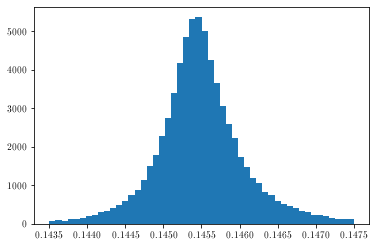

In [67]:
plt.hist(ak.flatten(Dst["Delta_M"]),bins=50)
plt.show()

Make $\tau$ from truth-matched combinations of three pions

In [68]:
tau = ak.combinations(pions,3)
tau["pi_1"], tau["pi_2"], tau["pi_3"] = ak.unzip(tau)

#Charge cut on the pions
tau_charge_cut_1 = np.sign(tau["pi_1","charge"]) != np.sign(tau["pi_3","charge"]) 
tau_charge_cut_2 = np.sign(tau["pi_2","charge"]) != np.sign(tau["pi_3","charge"])
tau_charge_cut = np.logical_and(tau_charge_cut_1, tau_charge_cut_2)

tau = tau[tau_charge_cut]

PDG_pi_m = lp.pi_plus.mass/1000.
tau["mass"] = kinematics_flat.mass([tau["pi_1"], tau["pi_2"], tau["pi_3"]], [PDG_pi_m, PDG_pi_m, PDG_pi_m])
tau_m_low_cut_val = 3*PDG_pi_m
tau_m_high_cut_val = lp.tau_plus.mass/1000.
tau_m_low_cut = tau["mass"] >= tau_m_low_cut_val
tau_m_high_cut = tau["mass"] <= lp.tau_plus.mass/1000.
tau_m_cut = np.logical_and(tau_m_low_cut, tau_m_high_cut)
tau = tau[tau_m_cut]

Keep only the ones where all pions have $\tau$ as a parent

In [69]:
tau_parent_cut_pi1 = abs(tau["pi_1"]["pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_pi2 = abs(tau["pi_2"]["pdg"]) == abs(lp.tau_plus.pdgid) 
tau_parent_cut_pi3 = abs(tau["pi_3"]["pdg"]) == abs(lp.tau_plus.pdgid)
tau_parent_cut_12 = np.logical_and(tau_parent_cut_pi1, tau_parent_cut_pi2)
tau_parent_cut_all = np.logical_and(tau_parent_cut_12, tau_parent_cut_pi3)
tau = tau[tau_parent_cut_all]
tau["charge"] = tau["pi_1","charge"] + tau["pi_2","charge"] + tau["pi_3","charge"]

Build $B$ from $D^*$ and $\tau$ 

In [71]:
B = ak.cartesian({"Dst": Dst, "tau": tau})
B_cut = np.sign(B["Dst","slow_pi","charge"]) != np.sign(B["tau","charge"]) 
B = B[B_cut]

B["mass"] = kinematics_flat.mass([B["Dst","D0","k"], 
                                  B["Dst","D0","pi"], 
                                  B["Dst","slow_pi"],
                                  B["tau","pi_1"],
                                  B["tau","pi_2"],
                                  B["tau","pi_3"]], 
                                 [PDG_K_m, 
                                  PDG_pi_m, 
                                  PDG_pi_m,
                                  PDG_pi_m,
                                  PDG_pi_m,
                                  PDG_pi_m
                                 ])

B_M_low = 2.8
B_M_high = 5.0
B_M_low_cut = B["mass"] >= B_M_low
B_M_high_cut = B["mass"] <= B_M_high
B_M_cut = np.logical_and(B_M_low_cut, B_M_high_cut)
B = B[B_M_cut]

Plot reco. $B$ mass

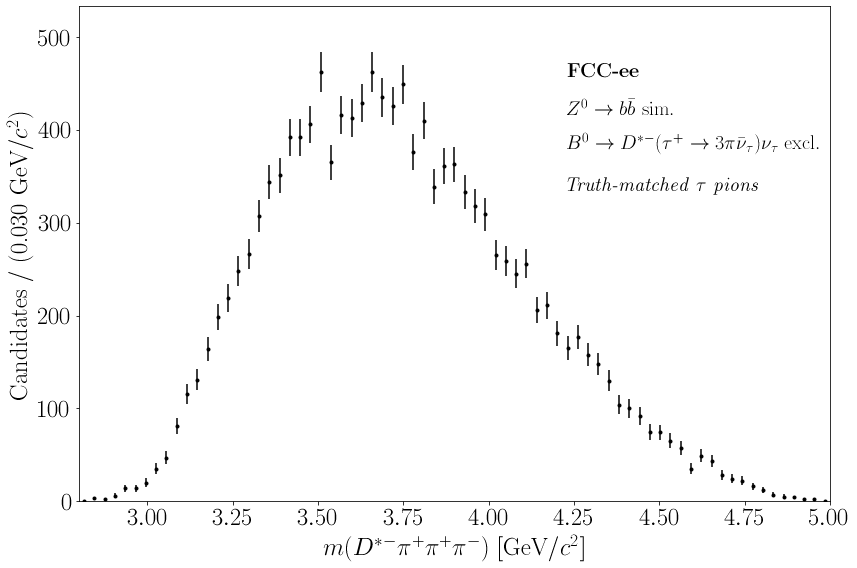

In [72]:
fig,ax = plt.subplots(figsize=(12,8))
low = B_M_low
high = B_M_high
bin_width = 0.03
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(ak.flatten(B["mass"]).tolist(), bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(D^{*-}\pi^+\pi^+\pi^-)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(4.23,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(4.23,0.82*ymax,"$Z^0 \\to b\\bar{b}$ sim.",fontsize=20)
plt.text(4.23,0.74*ymax,"$B^0 \\to D^{*-} (\\tau^+ \\to 3\pi \\bar{\\nu}_\\tau) \\nu_\\tau$ excl.",fontsize=20)
plt.text(4.23,0.66*ymax,"\\textit{Truth-matched} $\\tau$ \\textit{pions}",fontsize=20)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{mode}_B_M.pdf")

Plot $\tau$ mass for those used in $B$ candidates

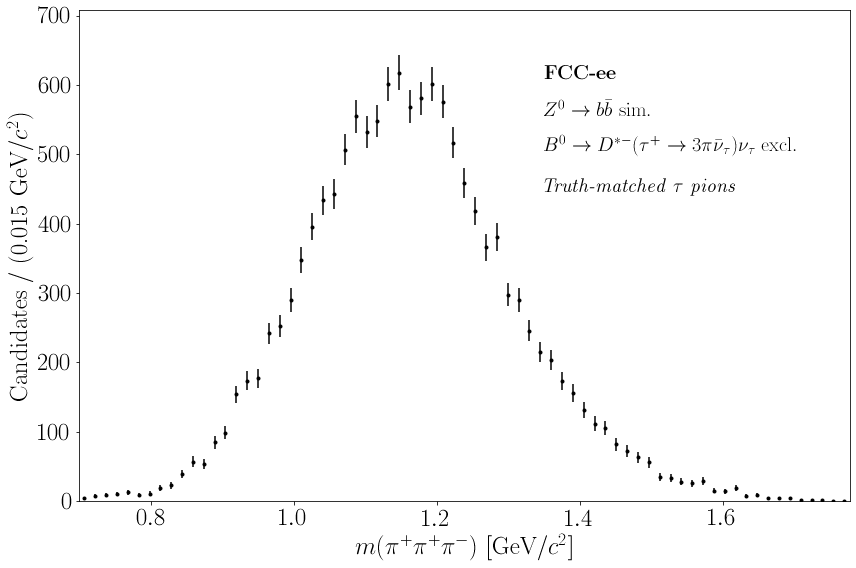

In [73]:
fig,ax = plt.subplots(figsize=(12,8))
low = 0.7
high = lp.tau_plus.mass/1000.
bin_width = 0.015
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(ak.flatten(B["tau","mass"]).tolist(), bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(\pi^+\pi^+\pi^-)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(1.35,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(1.35,0.82*ymax,"$Z^0 \\to b\\bar{b}$ sim.",fontsize=20)
plt.text(1.35,0.74*ymax,"$B^0 \\to D^{*-} (\\tau^+ \\to 3\pi \\bar{\\nu}_\\tau) \\nu_\\tau$ excl.",fontsize=20)
plt.text(1.35,0.66*ymax,"\\textit{Truth-matched} $\\tau$ \\textit{pions}",fontsize=20)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{mode}_Tau_M.pdf")

Fit $\Delta M = m(D^* - D^0)$ for selected events

In [74]:
low = Dst_Delta_M_low_cut_val
high = Dst_Delta_M_high_cut_val
obs = zfit.Space('mB', limits=(low, high))

#Signal PDF
rand = random.randint(0,9999)
mu = zfit.Parameter(f"mu_{rand}", 0.1455, low, high)
sigma = zfit.Parameter(f"sigma_{rand}", 0.0003, 0.0001, 0.1)
alphaL = zfit.Parameter(f"alphaL_{rand}", 0.5, 0., 5.)
nL = zfit.Parameter(f"nL_{rand}", 100., 0., 200.)
alphaR = zfit.Parameter(f"alphaR_{rand}", -0.5, -5., 0.)
nR = zfit.Parameter(f"nR_{rand}", 100., 0., 200.)
frac = zfit.Parameter(f"frac_{rand}", 0.2, 0., 1.)

pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaL, n=nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaR, n=nR)
pdf = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac)

In [75]:
data_np = ak.to_numpy(ak.flatten(B["Dst","Delta_M"]))
data = zfit.Data.from_numpy(obs=obs, array=data_np)

In [76]:
nll = zfit.loss.UnbinnedNLL(model=pdf, data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
param_errors = result.hesse()

print("m(D* - D0) fit function minimum:", result.fmin)
print("m(D* - D0) fit converged:", result.converged)
print("m(D* - D0) fit full minimizer information:", result.info)

params = result.params
print(params)

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -8.294e+04                 │      Ncalls = 1055 (1055 total)      │
│ EDM = nan (Goal: 0.001)          │               up = 0.5               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
m(D* - D0) fit function minimum: -82938.52858979492
m(D* - D0) fit converged: True
m(D* - D0) fit full minimizer information: {'n_eval': 1055, 'n_iter': 1055, 'original': FMin(fval=-82938.52858979492, edm=nan, tolerance=1.0, nfcn=1055, ncal

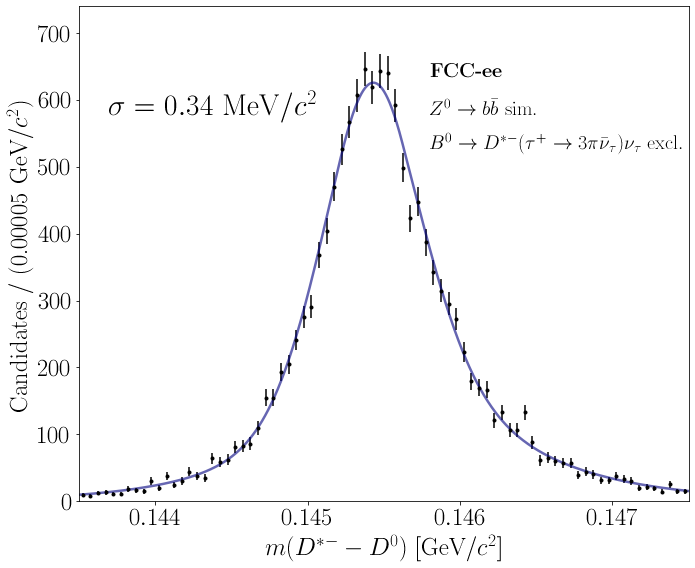

In [77]:
fig,ax = plt.subplots(figsize=(10,8))
lower, upper = obs.limits
low = lower[-1][0]
high = upper[0][0]
bin_width = 0.00005
bins = int(float(high - low)/bin_width)
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='black')
x_plot = np.linspace(low, high, num=1000)
y_plot_tot = zfit.run(pdf.pdf(x_plot, norm_range=obs))
plt.plot(x_plot, y_plot_tot*len(data_np)/bins*obs.area(), color='navy', linewidth=2.5, alpha=0.6)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.5f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(D^{*-} - D^0)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(0.1458,0.9*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(0.1458,0.82*ymax,"$Z^0 \\to b \\bar{b}$ sim.",fontsize=20)
plt.text(0.1458,0.74*ymax,"$B^0 \\to D^{*-} (\\tau^+ \\to 3\pi \\bar{\\nu}_\\tau) \\nu_\\tau$ excl.",fontsize=20)
sigma_val = 1000.*params[sigma]['value']
plt.text(0.1437,0.82*ymax,"$\\sigma = %.2f$ MeV/$c^2$" % sigma_val,fontsize=30)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{mode}_Dst_Delta_M_fit.pdf")

Non truth-matched combinations of three pions, to compare with the truth-matched

In [78]:
tau = ak.combinations(pions,3)
tau["pi_1"], tau["pi_2"], tau["pi_3"] = ak.unzip(tau)

#Charge cut on the pions
tau_charge_cut_1 = np.sign(tau["pi_1","charge"]) != np.sign(tau["pi_3","charge"]) 
tau_charge_cut_2 = np.sign(tau["pi_2","charge"]) != np.sign(tau["pi_3","charge"])
tau_charge_cut = np.logical_and(tau_charge_cut_1, tau_charge_cut_2)

tau = tau[tau_charge_cut]

PDG_pi_m = lp.pi_plus.mass/1000.
tau["mass"] = kinematics_flat.mass([tau["pi_1"], tau["pi_2"], tau["pi_3"]], [PDG_pi_m, PDG_pi_m, PDG_pi_m])
tau_m_low_cut_val = 3*PDG_pi_m
tau_m_high_cut_val = lp.tau_plus.mass/1000. 
tau_m_low_cut = tau["mass"] >= tau_m_low_cut_val
tau_m_high_cut = tau["mass"] <= tau_m_high_cut_val
tau_m_cut = np.logical_and(tau_m_low_cut, tau_m_high_cut)
tau = tau[tau_m_cut]

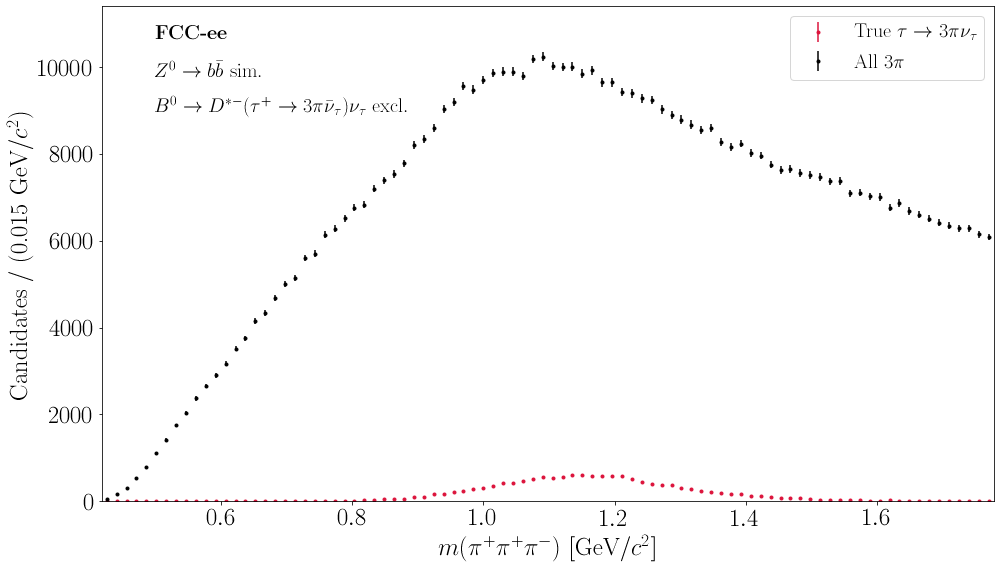

In [79]:
fig,ax = plt.subplots(figsize=(14,8))
low = tau_m_low_cut_val
high = tau_m_high_cut_val
bin_width = 0.015
bins = int(float(high - low)/bin_width)

#Genuine taus
counts, bin_edges = np.histogram(ak.flatten(B["tau","mass"]).tolist(), bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='crimson',label="True $\\tau \\to 3\\pi \\nu_\\tau$")

#All 3pi combos
counts, bin_edges = np.histogram(ak.flatten(tau["mass"]).tolist(), bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', markersize=3, color='k',label="All $3\\pi$")

ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_width,fontsize=25)
plt.xlabel("$m(\pi^+\pi^+\pi^-)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim()
plt.ylim(0,1.05*ymax)
plt.text(0.5,0.98*ymax,"\\textbf{FCC-ee}",fontsize=20)
plt.text(0.5,0.9*ymax,"$Z^0 \\to b\\bar{b}$ sim.",fontsize=20)
plt.text(0.5,0.82*ymax,"$B^0 \\to D^{*-} (\\tau^+ \\to 3\pi \\bar{\\nu}_\\tau) \\nu_\\tau$ excl.",fontsize=20)
plt.legend(loc='upper right',fontsize=20)
plt.tight_layout()
fig.savefig(loc.PLOTS+f"/{mode}_Tau_M_true_vs_all.pdf")

In [80]:
#Number of Z's produced per year (4) per experiment (2)
N_Z = 3e12 * 0.25 * 0.5
#Number of b quarks produced
N_b = 2 * 0.1512 * N_Z
#Number of B0 -> D* tau nu produced, 
N_Bd2DstTauNu = N_b * 0.43 * 0.0157 * 0.677 * 0.0395 * 0.098

print("N expected per year per exp = %.3e" % N_Bd2DstTauNu)

N expected per year per exp = 2.006e+06
